# Capstone Part 5: Yearly Mean Solar data
## By Elizabeth Tyree


### Problem Statement:
### Can the occurrence of sunspots be used to predict the frequency of earthquakes?

## Executive Summary: 
This project uses machine learning tools such as the ARMA, SARIMAX, and LSTM’s, to predict sunspots using yearly mean sunspot numbers from the Sunspot Index and Long-term Solar Observations (SILSO) data, Royal Observatory of Belgium, Brussels. The models are compared to each other for accuracy of prediction. The goal is to see if machine learning can help settle the debate on weather or not Sunspots and Earthquakes have any correlation with each other. 

This goal is approached in Three phases, however this capstone at the moment is only concerned with Phase 1. Here are the phases of this project and the overall importance to provide clarity with respect to the overarching context of this capstone. 

    -> Phase 1: Sunspot Modeling using ARMA, SARIMAX, and LSTM
    -> Phase 2: Earthquake Modeling using SARIMAX, and LSTM
 
Importance: The ability to predict earthquakes or at least better understand them may lead to saving lives and reducing the impact of earthquakes through better preparedness. Within the scientific community there is a debate as to weather or not sunspots and earthquakes on earth are correlated. Usually this debate falls into one of two categories, 1) There is no correlation between sunspots and earthquakes. If you see a pattern, it’s not real. Or, 2) Sunspots and earthquakes may be correlated, more research needs to be done.

Phase 1 scope: To use machine learning to 

Milestones and Key Metrics: 

The SARIMAX numerically performed the best, had the lowest scores of all three Models. (This was a surprise!)
Both the SARIMAX and LSTM were good at capturing the overall solar cycle, but the LSTM was the best at capturing some of the finer details of the high’s and lows of the solar data out of all 3 Models.
The ARMA performed the worst but had better scores than the LSTM.


Conclusions and Recommendations:  Out of all three models the LSTM performed the best with respect to mean absolute error. 

Most important: 

    -> Understanding time series based tools when applied to noisy, high variability data with hard to predict seasonality and trends.

Recommend redoing analysis with Monthly and Daily solar data. 

    -> Add other performance metrics.
    -> Signal Analysis as a performance metric.




## Overall Capstone Outline

Part 1: Data Summary | Datasets in possession 

-> Yearly Mean Sunspot Numbers Source: WDC-SILSO, Royal Observatory of Belgium, Brussels.

    File Name: SN_y_tot_V2.0.txt
    Data Format: plain ASCII text
    Features: Frac_Year, Yearly_Mean_Sunspot_Number, Std, Number_of_observations, Definitive_provisional_indicator 
    Date Range: 1700 to 2017 
    Note: The file itself does not contain headers.


-> The Centennial catalog from the USGS, contains earthquakes from 1900 to 2007.

    File Name: Centennial_Y2K.cat
    Data Format: *.cat (csv)
    Features: icat, msc1, mdo1, yr, mon, Day, hr, Min, sec, glat, glon, dep, greg, ntel, mag1, Fract_Year
    Date Range: 01/01/1903 to 09/30/2007
    
-> Reviewed Earthquakes data from the USGS 1900-2016 all magnitudes.
    
    File Name: RevCatAllM_1900-2016_rev3.txt
    Data Format: csv
    Features: time, latitude, longitude, depth, mag, magType, nst, gap, dmin, rms, net, id, updated, place, type, 
    horizontalError, depthError, magError, magNst, status, locationSource, magSource
    Date Range: 1900-2016
    
-> International Seismological Centre (ISC) catalog of earthquakes from 1900 to 2016.

    Data Format: *.csv
    Features: 
    Date Range: 1900-2016
    
Part 2: Data Cleaning and Exploratory Data Analysis (EDA)

[Part 3: Using Yearly Average Sunspot Numbers for Model 1: ARMA](https://github.com/LeMaylon/capstone/blob/master/Capstone%20_5_Part_3_ARMA_20180717.ipynb)

Part 4: Using Yearly Average Sunspot Numbers for Model 2: SARIMAX

Part 5: Using Yearly Average Sunspot Numbers for Model 3: LSTM


In [1]:
# Importing Libraries

import numpy as np
np.random.seed(19680801)

import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import datetime as dt
from datetime import timedelta
from datetime import datetime
import time
#from datetime import now

#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 # Use this at the command line to expand rate limit!
# or the function prep_posts may not work properly.
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None) 
%matplotlib inline

# Part 2: Data Cleaning and Exploratory Data Analysis (EDA)

In [2]:
# Loading the Yearly mean sunspot data, these are the yearly mean sunspot numbers.
# Data dictionary that is copied and pasted below, can be found here: http://www.sidc.be/silso/infosndtot
# Sunspot data source: SILSO data, Royal Observatory of Belgium, Brussels.
'''
Time range: 1700 - last elapsed year

Data description:
Yearly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each year. (NB: in early years in particular before 1749, the means are computed on only a fraction of the days in each year because on many days, no observation is available).

Error values:
The yearly standard deviation of individual data is derived from the daily values by the same formula as the monthly means:
sigma(m)=sqrt(SUM(N(d)*sigma(d)^2)/SUM(N(d)))
where sigma(d) is the standard deviation for a single day and N(d) is the
number of observations for that day.

The standard error on the yearly mean values can be computed by:
sigma/sqrt(N) where sigma is the listed standard deviation and N the total number of observations in the year.
NB: this standard error gives a measure of the precision, i.e. the sensitivity of the yearly value to different samples of daily values with random errors. The uncertainty on the mean (absolute accuracy) is only determined on longer time scales, and is thus not given here for individual yearly values.

-------------------------------------------------------------------------------
TXT
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.txt
Format: plain ASCII text

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the yearly average still contains provisional daily values and is subject to a possible revision.

Line format [character position]:
- [1-6] Year (decimal)
- [9-13] Yearly mean total sunspot number
- [15-19] Standard deviation
- [22-26] Number of observations
- [28] Definitive/provisional indicator

-------------------------------------------------------------------------------
CSV
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.
''';

# Headers for the sunspot data.
my_cols_y = ['Frac_Year','Yearly_Mean_Sunspot_Number','y_Std','Number_of_observations', 'Definitive_provisional_indicator'] # The file does not contain headers.

# Loading the data file
ISSN_Y_tot = pd.read_csv('./data/SN_y_tot_V2.0.csv',names=my_cols_y,sep=';', engine='python')

In [3]:
ISSN_Y_tot.head() # Checking that the data loaded properly by viewing the head.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [8]:
ISSN_Y_tot.tail() # Viewing the tail of the sunspot data

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


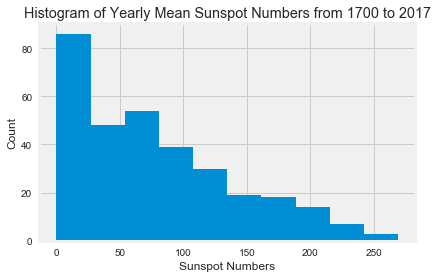

In [9]:
# Histogram of Yearly mean Sunspot Numbers from the ISSN.
#bin_size = 0.5
#n_bins = 10/bin_size


plt.hist(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'])    
# Add title and axis names
plt.title('Histogram of Yearly Mean Sunspot Numbers from 1700 to 2017')
plt.xlabel('Sunspot Numbers') #Default is 10 bins
plt.ylabel('Count')
#plt.xlim(0,10)

# Show graphic
plt.show()

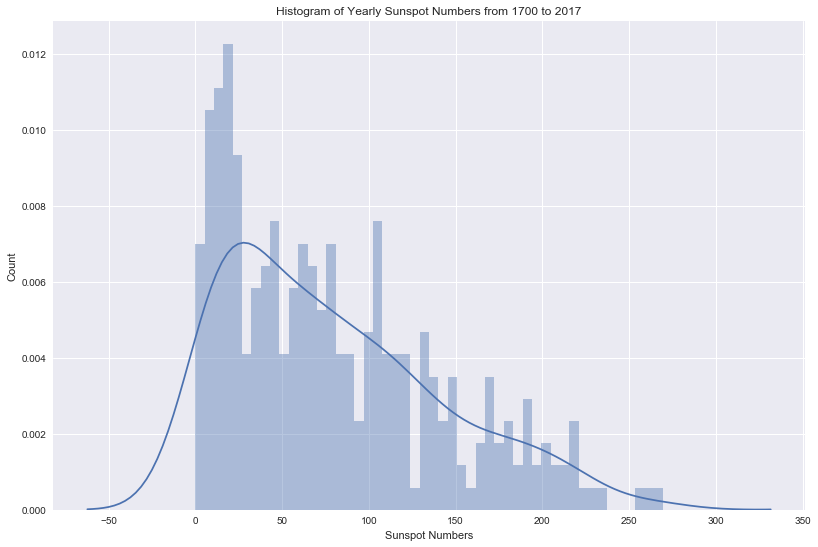

In [10]:
sns.set(rc={'figure.figsize':(12,9)})
f,ax = plt.subplots()
sns.distplot(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'], bins=50, axlabel ='Sunspot Numbers')
ax.set_title('Histogram of Yearly Sunspot Numbers from 1700 to 2017')
ax.set_xlabel('Sunspot Numbers');
ax.set_ylabel('Count');

In [11]:
# Crosstab of Sunspot numbers.
pd.crosstab(index=ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],  # Make a crosstab
                      columns="count")      # Name the count column

col_0,count
Yearly_Mean_Sunspot_Number,
0.0,3
2.2,1
2.3,1
2.4,1
3.3,1
4.2,2
4.6,1
4.8,1
5.0,1


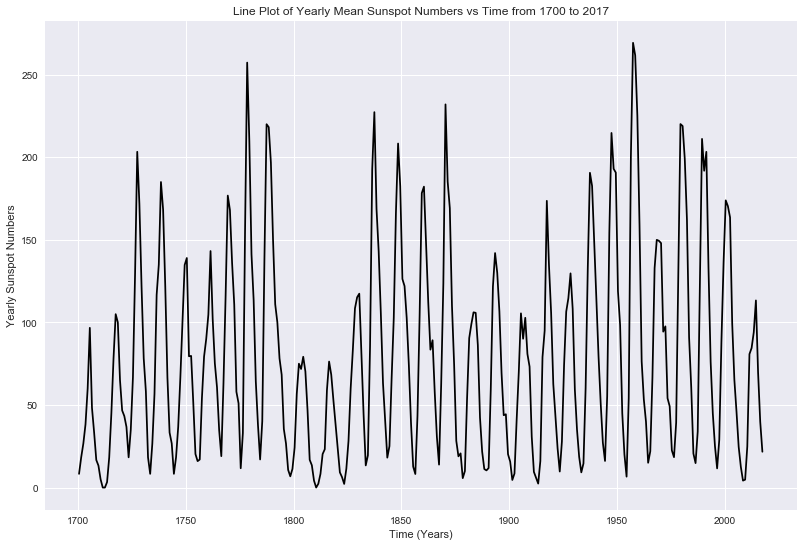

In [12]:
# Plotting the Sunspot numbers vs time in Years.
plt.plot(ISSN_Y_tot['Frac_Year'],ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],'k-')

# Add title and axis names
plt.title('Line Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2017')
plt.xlabel('Time (Years)') #Default is 10 bins
plt.ylabel('Yearly Sunspot Numbers')
#plt.xlim(0,10)

# Show graphic
plt.show()

In [22]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Decomposing the Time stamp

In [13]:
yearly_sun = ISSN_Y_tot.copy() # Making a copy of the sunspot data.

# Creating a new Date feature
yearly_sun['Date'] = yearly_sun['Frac_Year'].astype(int) # Converting the fraction year to an integer.
yearly_sun['Date'] = pd.to_datetime(yearly_sun['Date'], format='%Y') # Converting data type to a timedate type.
delta_t = datetime(1701,1,1) - datetime(1700,1,1) # delta_t is 1 year.


yearly_sun['Date'] = yearly_sun.Date + delta_t # Adding delta_t to the date
yearly_sun.set_index('Date', inplace=True) # Setting the Date column as the index.


In [14]:
yearly_sun.head() # Viewing the head to see if the changes persisted.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
Date,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1
1702-01-01,1701.5,18.3,-1.0,-1,1
1703-01-01,1702.5,26.7,-1.0,-1,1
1704-01-01,1703.5,38.3,-1.0,-1,1
1704-12-31,1704.5,60.0,-1.0,-1,1


In [15]:
yearly_sun.index # Verifying the Date is now a Datetime Index

DatetimeIndex(['1701-01-01', '1702-01-01', '1703-01-01', '1704-01-01',
               '1704-12-31', '1706-01-01', '1707-01-01', '1708-01-01',
               '1708-12-31', '1710-01-01',
               ...
               '2008-12-31', '2010-01-01', '2011-01-01', '2012-01-01',
               '2012-12-31', '2014-01-01', '2015-01-01', '2016-01-01',
               '2016-12-31', '2018-01-01'],
              dtype='datetime64[ns]', name='Date', length=318, freq=None)

In [16]:
# Setting the frequency to be yearly for the index.
yearly_sun.index = pd.date_range('1/1/1700', 
                          periods=len(yearly_sun.index),name='Date', freq='Y')

In [17]:
yearly_sun.index # Making sure the "freq=None" has changed to "freq='A-DEC'".

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq='A-DEC')

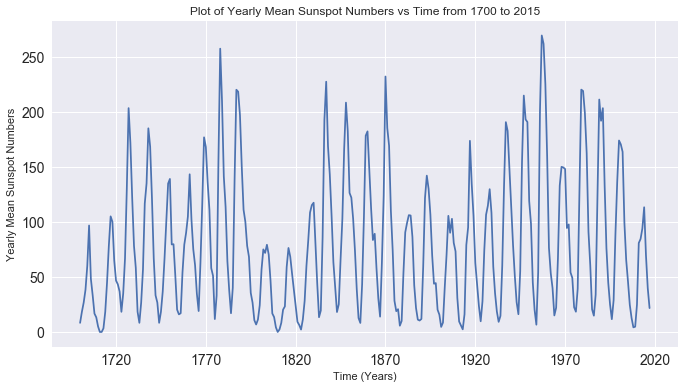

In [18]:
# Plotting the yearly mean sunspot numbers vs. time in Years.
yearly_sun.Yearly_Mean_Sunspot_Number.plot(figsize=(10,6), title= 'Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2015', fontsize=14)
plt.xlabel('Time (Years)'); 
plt.ylabel('Yearly Mean Sunspot Numbers');

## Pre Model Staging: 
## Decomposing the Time Series data, looking at the plots for trends and seasonality 

In [19]:
yearly_sun.dtypes

Frac_Year                           float64
Yearly_Mean_Sunspot_Number          float64
y_Std                               float64
Number_of_observations                int64
Definitive_provisional_indicator      int64
dtype: object

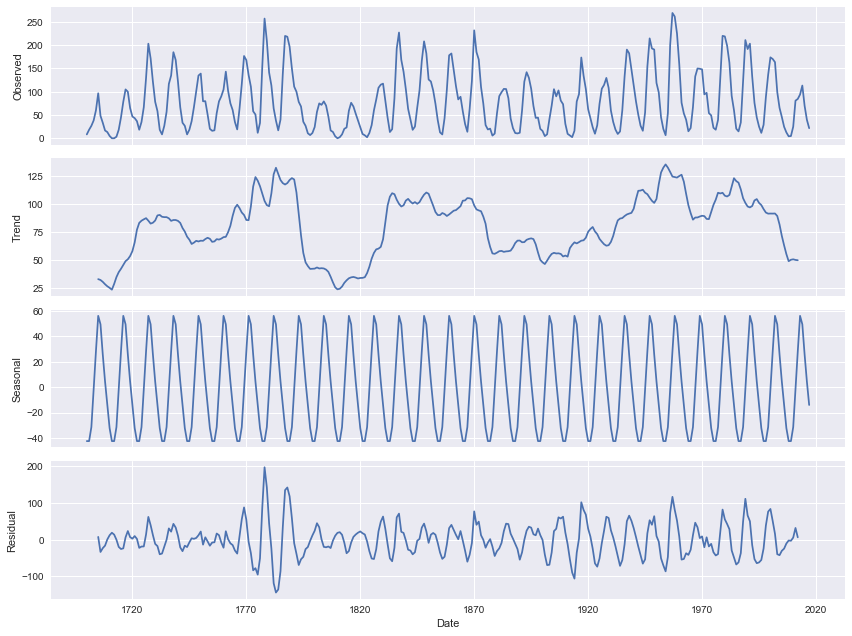

In [23]:
decomposition = seasonal_decompose(yearly_sun.Yearly_Mean_Sunspot_Number, freq=11)# You originally had 11 for one solar cycle.
decomposition.plot();

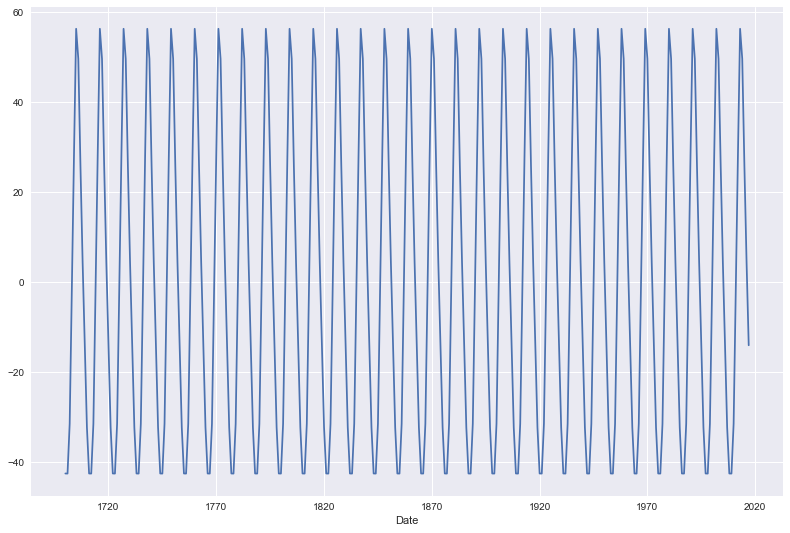

In [24]:
# Ploting only the seasonal componet
seasonal = decomposition.seasonal 
seasonal.plot()

## Utilizing the Dickey-Fuller test for stationartity of the data series.

In [25]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=11, center=False).mean()
    rolstd = timeseries.rolling(window=11, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = timeseries.plot(color='blue',label='Original')
    mean = rolmean.plot(color='red', label='Rolling Mean')
    std = rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )


###### Perform the test.
test_stationarity(yearly_sun.Yearly_Sun_Spot_Number)

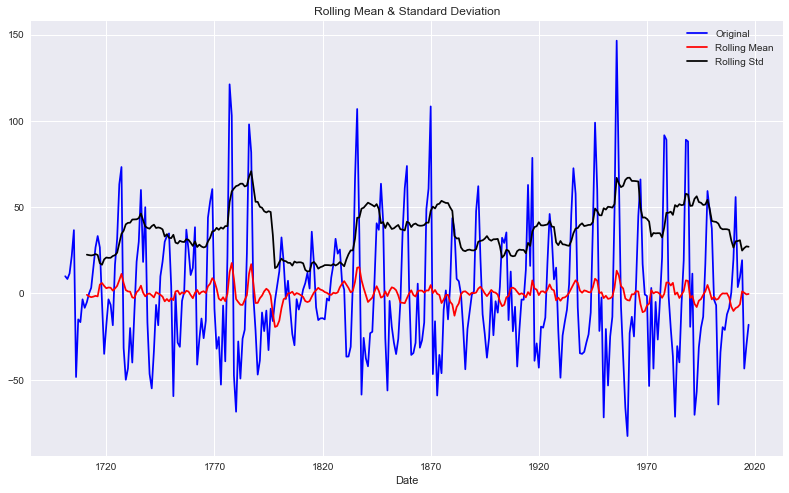

Results of Dickey-Fuller Test:
Test Statistic   -1.486027e+01
p-value           1.723470e-27
dtype: float64


In [26]:
# First difference:
yearly_sun['first_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff()
test_stationarity(yearly_sun.first_difference.dropna())

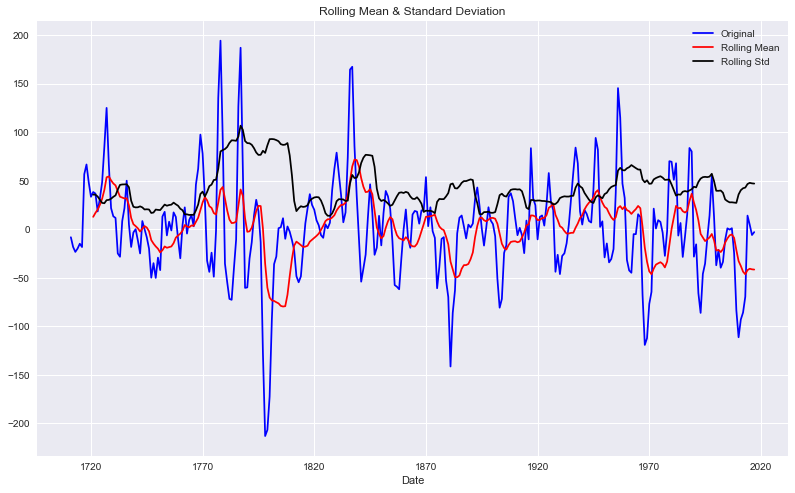

Results of Dickey-Fuller Test:
Test Statistic   -4.351080
p-value           0.000362
dtype: float64


In [29]:
# Seasonal difference:
yearly_sun['seasonal_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_difference.dropna())

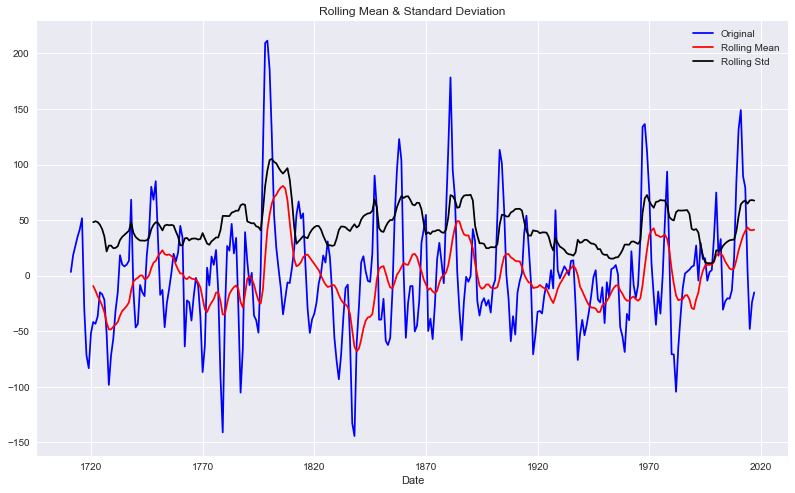

Results of Dickey-Fuller Test:
Test Statistic   -3.739598
p-value           0.003589
dtype: float64


In [30]:
# First seasonal difference:
yearly_sun['seasonal_first_difference'] = yearly_sun.first_difference - yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_first_difference.dropna())

In [44]:
truth = test.seasonal_first_difference # Setting test data as truth data


In [602]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

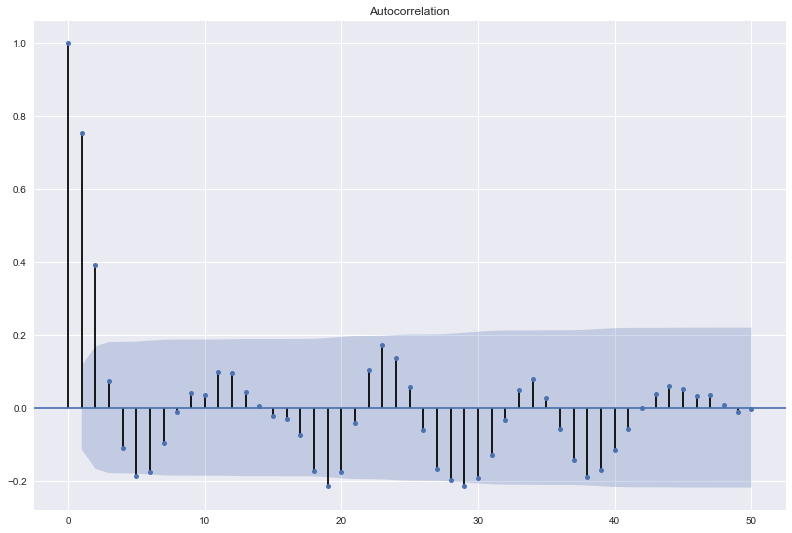

In [39]:
plot_acf(train.seasonal_first_difference.values,lags=50);

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf

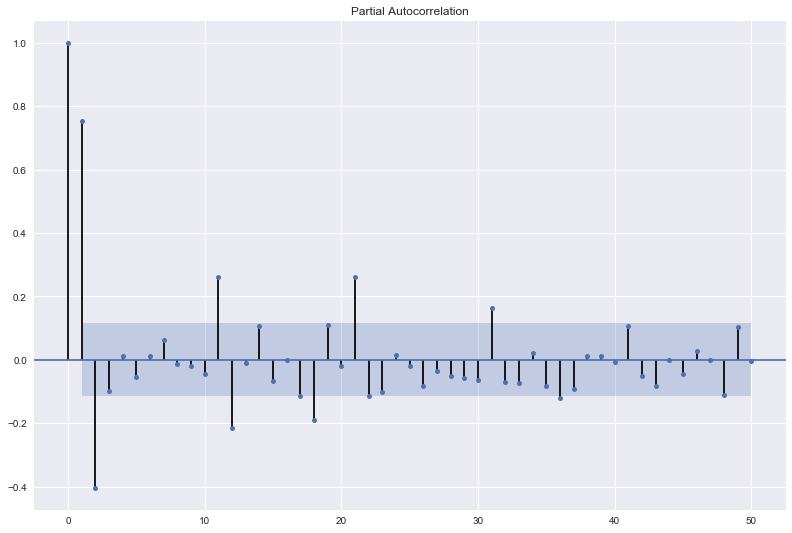

In [41]:
plot_pacf(train.seasonal_first_difference.values, lags=50);

In [64]:
y_sun = yearly_sun.Yearly_Mean_Sunspot_Number
y_sun_diff = y_sun.diff(11).dropna()

undo_diff = []
undo_diff.append(y_sun[0:11])


for val in y_sun_diff:
    undo_diff.append(val + undo_diff[-1])  
    
    
undo_diff;

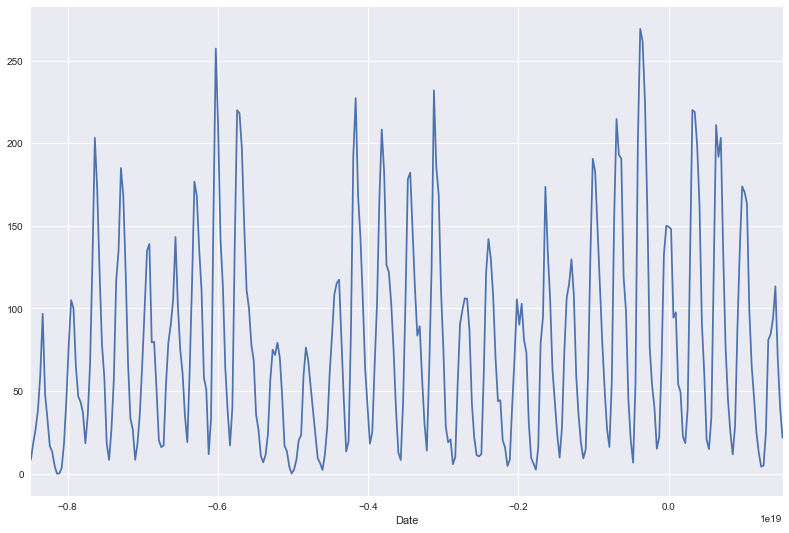

In [83]:
sns.tsplot(yearly_sun.Yearly_Mean_Sunspot_Number,time=yearly_sun.index)

In [63]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


# [Part 3: Using Yearly Average Sunspot Numbers for Model 1: ARMA](https://github.com/LeMaylon/capstone/blob/master/Capstone%20_5_Part_3_ARMA_20180717.ipynb)

In [ ]:
# Note the Link above will take you to a different notebook with the ARMA Model.


# Part 4: Using Yearly Average Sunspot Numbers for Model 2: SARIMAX

In [293]:
sari_sun = ISSN_Y_tot.copy()

#yearly_sun['Frac_Year'] = pd.to_datetime(yearly_sun['Frac_Year'])
sari_sun['Date'] = sari_sun['Frac_Year'].astype(int)
sari_sun['Date'] = pd.to_datetime(sari_sun['Date'], format='%Y')
delta_t = datetime(1701,1,1) - datetime(1700,1,1)

sari_sun['Date'] = sari_sun.Date + delta_t
sari_sun.set_index('Date', inplace=True)

In [294]:
sari_sun.dtypes

Frac_Year                           float64
Yearly_Mean_Sunspot_Number          float64
y_Std                               float64
Number_of_observations                int64
Definitive_provisional_indicator      int64
dtype: object

In [295]:
sari_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
Date,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1
1702-01-01,1701.5,18.3,-1.0,-1,1
1703-01-01,1702.5,26.7,-1.0,-1,1
1704-01-01,1703.5,38.3,-1.0,-1,1
1704-12-31,1704.5,60.0,-1.0,-1,1


## Decompose the Time Series for the SARIMAX and Plot

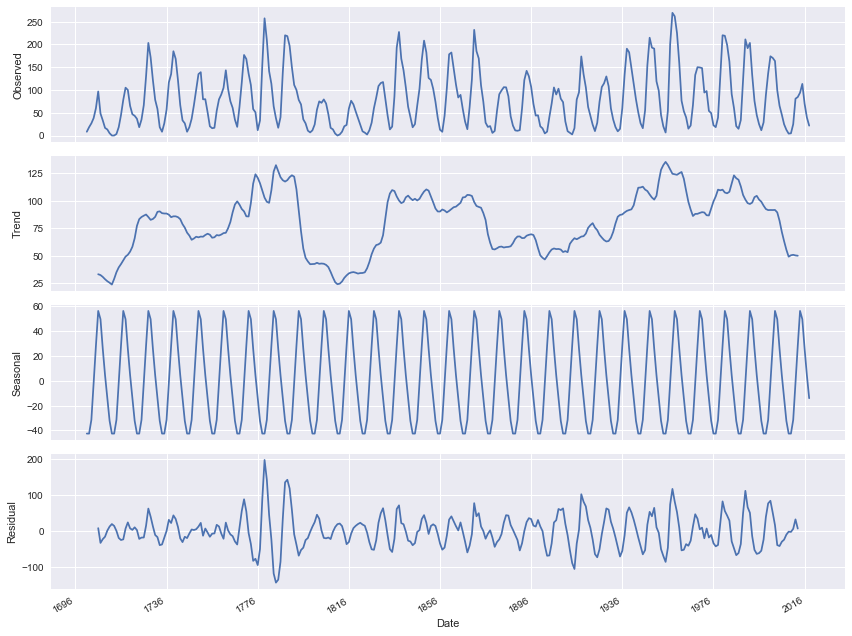

In [296]:
decomposition = seasonal_decompose(sari_sun.Yearly_Mean_Sunspot_Number, freq=11)# You originally had 11 for one solar cycle.
decomposition.plot();

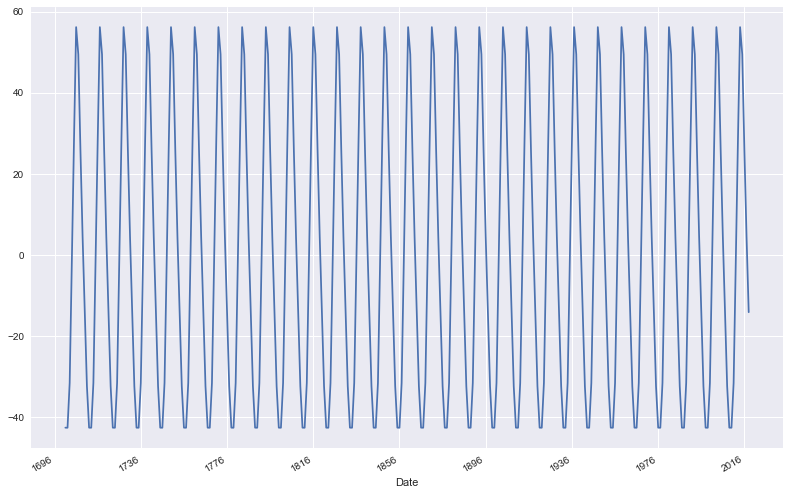

In [297]:
# Ploting only the seasonal componet
seasonal = decomposition.seasonal 
seasonal.plot()

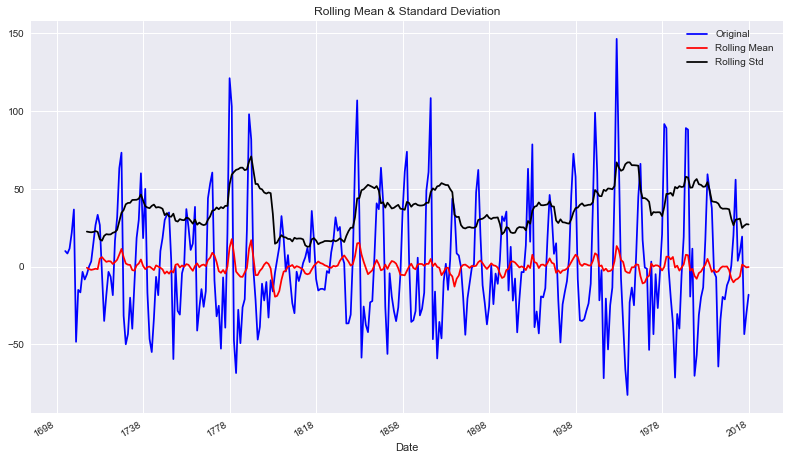

Results of Dickey-Fuller Test:
Test Statistic   -1.486027e+01
p-value           1.723470e-27
dtype: float64


In [298]:
# First difference:
sari_sun['first_difference'] = sari_sun.Yearly_Mean_Sunspot_Number.diff()
test_stationarity(sari_sun.first_difference.dropna())

In [299]:
sari_sun.head(2)

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference
Date,,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1,NaN
1702-01-01,1701.5,18.3,-1.0,-1,1,10.0


In [300]:
import statsmodels.api as sm
# Grid search by setting up your own loop. No need to use the gridsearch function.
p = 0
d = 1 #Notes: do a manual diff of 1 year. (You do not need to give your manual diff to sarimax, just us it to determine seasonality using pacf.)
q = 1

P = 1
D = 1 # D is 11 years
Q = 0
s = 11 # You are chooing the season order

data = sari_sun[['Yearly_Mean_Sunspot_Number']].stack().values
#data = sari_sun[['Yearly_Mean_Sunspot_Number']].stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,s),enforce_stationarity=True,enforce_invertibility=True)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  318
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 11)   Log Likelihood               -1500.141
Date:                            Mon, 16 Jul 2018   AIC                           3006.281
Time:                                    13:48:01   BIC                           3017.567
Sample:                                         0   HQIC                          3010.789
                                            - 318                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3116      0.045      6.987      0.000       0.224       0.399
ar.S.L11      -0.4033      0.050   

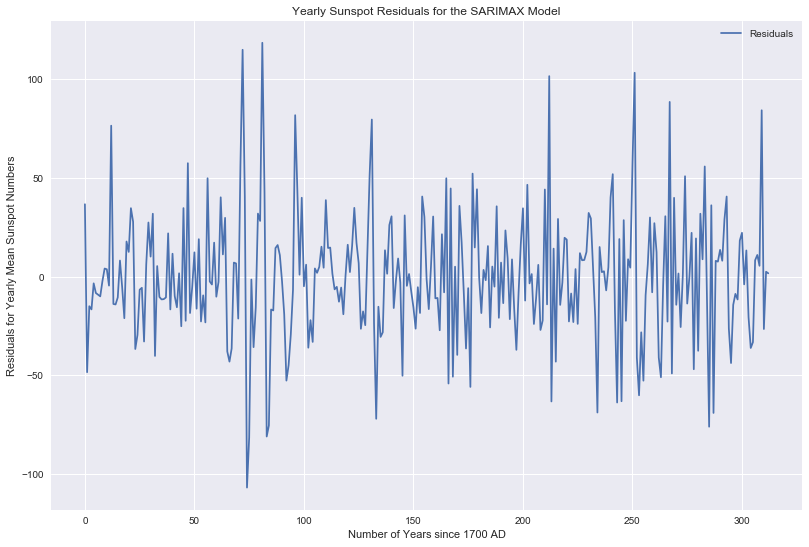

In [301]:
#Plot the residuals of the SARIMAX model.
# Don't plot the first five values to account for data loss when differencing (d=1 + D=5).
residuals = results.resid[5:]
plt.plot(residuals, label='Residuals')
plt.title('Yearly Sunspot Residuals for the SARIMAX Model')
plt.ylabel('Residuals for Yearly Mean Sunspot Numbers') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

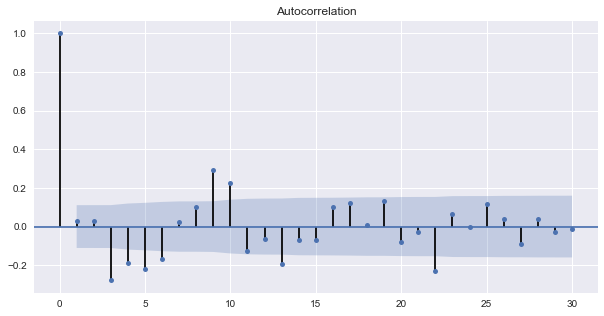

In [302]:
# Plot the ACF and PACF of the residuals.
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

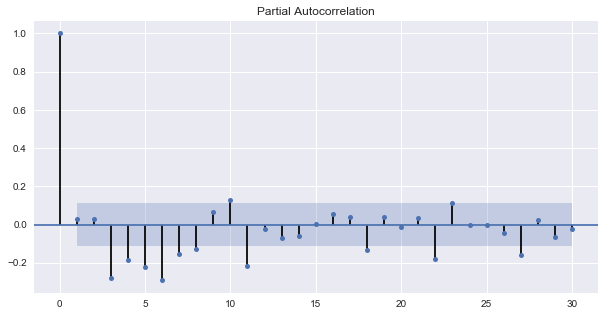

In [303]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

In [304]:
train_test = sari_sun.copy()
train_test.reset_index('Date', inplace=True) # Setting the Date column as the index.

train_test.dropna(inplace=True)


train = train_test.head(300)
test = train_test.tail(17)

In [305]:
train_test.head()

,Date,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference
1,1702-01-01,1701.5,18.3,-1.0,-1,1,10.0
2,1703-01-01,1702.5,26.7,-1.0,-1,1,8.4
3,1704-01-01,1703.5,38.3,-1.0,-1,1,11.6
4,1704-12-31,1704.5,60.0,-1.0,-1,1,21.7
5,1706-01-01,1705.5,96.7,-1.0,-1,1,36.7


In [275]:
start = test.index[0].to_pydatetime()
print('Start date for test is {}'.format(start))
end = test.index[-1].to_pydatetime()
print('End date for test is {}'.format(end))

Start date for test is 2002-01-01 00:00:00
End date for test is 2018-01-01 00:00:00


In [306]:
len(train_test)

317

In [307]:
train.tail(2) 


,Date,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference
299,2000-01-01,1999.5,136.3,9.3,6413,1,48.0
300,2000-12-31,2000.5,173.9,10.1,5953,1,37.6


In [308]:
sari_sun.Yearly_Mean_Sunspot_Number.tail()

Date
2014-01-01     94.0
2015-01-01    113.3
2016-01-01     69.8
2016-12-31     39.8
2018-01-01     21.7
Name: Yearly_Mean_Sunspot_Number, dtype: float64

In [309]:
#truth = test.seasonal_first_difference

pres = results.predict(start=301, end=317, dynamic=False)
#pres = results.predict(start=test.index[0], end=test.index[-1], dynamic=False)


#pres = results.predict(dynamic= False)

In [612]:
print(mean_absolute_error(test.Yearly_Mean_Sunspot_Number, pres))
print(mean_squared_error(test.Yearly_Mean_Sunspot_Number, pres)**0.5)
#print(mean_absolute_error(sari_sun.Yearly_Mean_Sunspot_Number, pres))

18.936206825295944
26.902943631660108


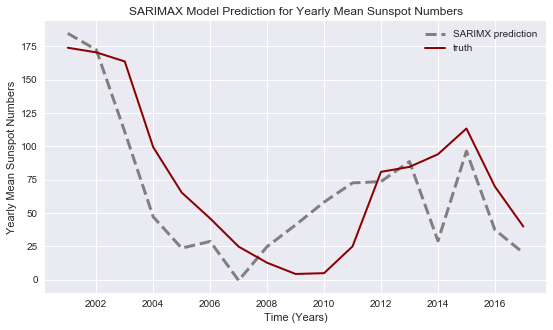

In [611]:
plt.subplots(figsize=(8,5))
plt.plot(sari_sun.index[300:317],pres, lw=3, color='grey', ls='dashed', label='SARIMX prediction')
plt.plot(sari_sun.index[300:317],sari_sun.Yearly_Mean_Sunspot_Number[300:317],lw=2, color='darkred', label = 'truth')
plt.title('SARIMAX Model Prediction for Yearly Mean Sunspot Numbers')
plt.xlabel('Time (Years)'); 
plt.ylabel('Yearly Mean Sunspot Numbers');

plt.legend()

In [312]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


## Using Yearly Average Sunspot Numbers for Model 3: LSTM

In [313]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Predicting First Difference Sunspot Numbers

In [314]:
# Normalize the differenced first_difference sunspot data with MinMaxScaler
# The rate to be restricted to the range -1 to 1.
sunny = sari_sun[['first_difference']].iloc[1:, :]

mms = MinMaxScaler(feature_range=(-1, 1))
sunny = mms.fit_transform(sunny)

print(sunny.shape)


(317, 1)


In [420]:
train_size = len(sunny) - 17
test_size = len(sunny) - train_size
print(len(sunny), train_size, test_size)

train_lstm, test_lstm = sunny[0:train_size,:], sunny[train_size:len(sunny),:]

317 300 17


In [421]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [422]:
X, y = create_data(sunny[:8], lag=3, as_array=False)

In [423]:
X

,lag1,lag2,lag3
0,-0.177652,-0.205587,-0.191619
1,-0.089481,-0.177652,-0.205587
2,0.041467,-0.089481,-0.177652
3,-0.701440,0.041467,-0.089481
4,-0.409865,-0.701440,0.041467


In [424]:
# Create training and testing data for a lag of 1
# This means  X will just have 1 column.

lag = 1
train_X, train_Y = create_data(train_lstm, lag)
test_X, test_Y = create_data(test_lstm, lag)

## Reshape the data to work with the LSTM
---

The format of data the LSTM expects is:

    [samples, time_steps, features]
    
where

- `samples`: number of observations,
- `time_steps`: number of (lagged) time steps to use in the prediction,
- `features`: number of features/sequences to use in the prediction.
    
This is a 3D matrix.

We have been using 2D predictor matrices for our machine learning algorithms, where our X predictor matrix has been in the form:

    [samples, features]

Since we are working with timeseries (which is the data an LSTM expects), we are now required to provide information about the time.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line. 

> **Note:** In the case of a single lag this time step dimension is redundant. Later on, when we redesign the X matrix so that our individual features have multiple timesteps, this 3D format requirement will be clearer.

In [425]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [426]:
print(train_X.shape, train_Y.shape)

(299, 1, 1) (299,)


In [427]:
# Model
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, 
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (1, 4)                    96        
_________________________________________________________________
dense_12 (Dense)             (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [428]:
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(20):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 3s 9ms/step - loss: 0.1197 - val_loss: 0.0646
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 2s 6ms/step - loss: 0.1114 - val_loss: 0.0644
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 1s 4ms/step - loss: 0.1069 - val_loss: 0.0645
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 2s 6ms/step - loss: 0.1023 - val_loss: 0.0702
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 1s 5ms/step - loss: 0.0995 - val_loss: 0.0844
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 2s 6ms/step - loss: 0.0961 - val_loss: 0.0897
Train on 299 samples, validate on 16 samples
Epoch 1/1
299/299 [==============================] - 2s 7ms/step - loss: 0.0881 - val_loss:

In [429]:
len(sari_sun.index[0:-1])

317

MAE =  0.37959118077668863
MSE =  0.22621083849769386


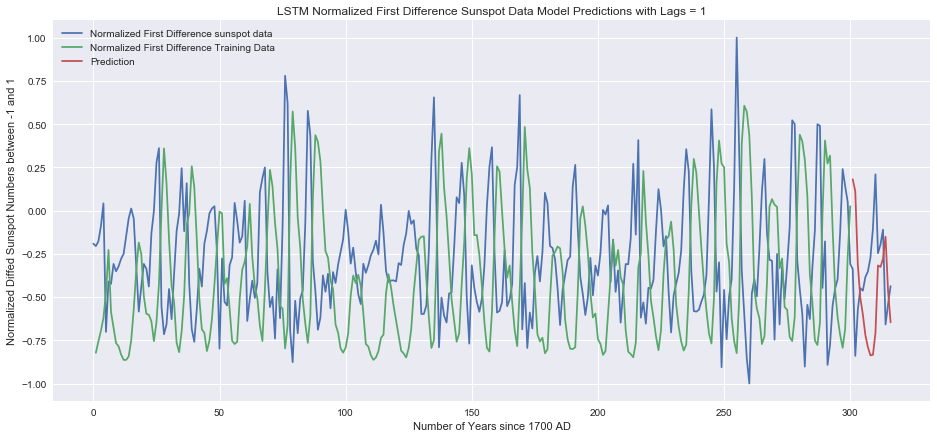

In [600]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))
print('MSE = ', mean_squared_error(test_observed, test_predict))


# shift train predictions for plotting
train_predict_plot = np.empty_like(sunny)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sunny)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny, label='Normalized First Difference sunspot data')
plt.plot(train_predict_plot, label='Normalized First Difference Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized First Difference Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Normalized Diffed Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')

plt.legend()
plt.show()

# Part 5: Using Yearly Average Sunspot Numbers for Model 3: LSTM

In [537]:
# Normalize the differenced first_difference sunspot data with MinMaxScaler
# The rate to be restricted to the range -1 to 1.
sunny_spots = sari_sun[['Yearly_Mean_Sunspot_Number']]
#sunny_spots = sari_sun[['Yearly_Mean_Sunspot_Number']].iloc[1:, :]

mms = MinMaxScaler(feature_range=(-1, 1))
sunny_spots = mms.fit_transform(sunny_spots)

print(sunny_spots.shape)


(318, 1)


In [581]:
train_size = len(sunny_spots) - 17
test_size = len(sunny_spots) - train_size
print(len(sunny_spots), train_size, test_size)

train_lstm, test_lstm = sunny_spots[0:train_size,:], sunny_spots[train_size:len(sunny_spots),:]

318 301 17


In [582]:

X, y = create_data(sunny_spots[:8], lag=1, as_array=False)

In [590]:
lag = 1
train_X, train_Y = create_data(train_lstm, lag)
test_X, test_Y = create_data(test_lstm, lag)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X[0:5])

[[[-0.93835871]]

 [[-0.86409209]]

 [[-0.80170813]]

 [[-0.71555886]]

 [[-0.5544003 ]]]


In [591]:
print(train_X.shape, train_Y.shape)

(300, 1, 1) (300,)


In [592]:
# Model
np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, 
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 4)                    96        
_________________________________________________________________
dense_32 (Dense)             (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


np.random.seed(42)

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, 1, lag), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [593]:
for i in range(30):
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    
    model.reset_states()

Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 4s 13ms/step - loss: 0.2209 - val_loss: 0.1112
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 8ms/step - loss: 0.1797 - val_loss: 0.1004
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 7ms/step - loss: 0.1709 - val_loss: 0.0970
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 7ms/step - loss: 0.1624 - val_loss: 0.0960
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 7ms/step - loss: 0.1582 - val_loss: 0.0977
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 8ms/step - loss: 0.1515 - val_loss: 0.0960
Train on 300 samples, validate on 16 samples
Epoch 1/1
300/300 [==============================] - 2s 8ms/step - loss: 0.1409 - val_loss

MAE =  0.37959118077668863
MSE =  0.22621083849769386


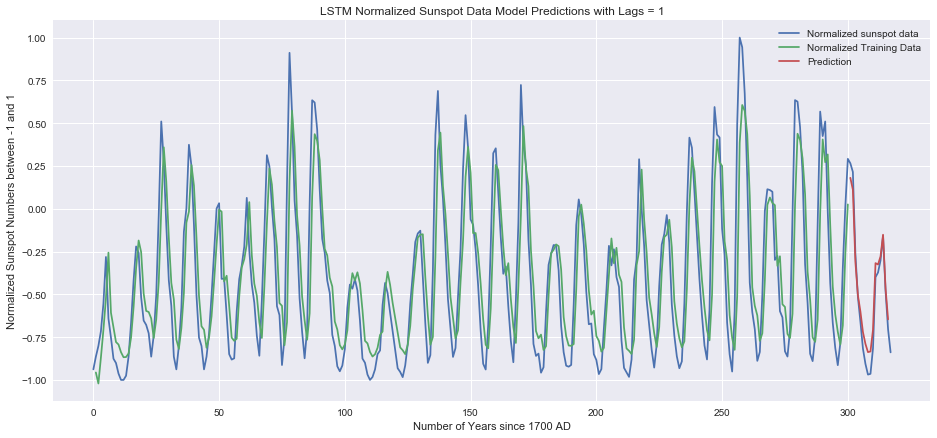

In [597]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.reset_states()
train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = sunny[-len(test_predict):, :]

print('MAE = ', mean_absolute_error(test_observed, test_predict))
print('MSE = ', mean_squared_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(sunny)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(sunny)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny_spots, label='Normalized sunspot data')
plt.plot(train_predict_plot, label='Normalized Training Data')
plt.plot(test_predict_plot, label='Prediction')
plt.title('LSTM Normalized Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Normalized Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

In [595]:
sunny_spots;

MAE =  51.111953770287016
RMSE =  64.04173279482075


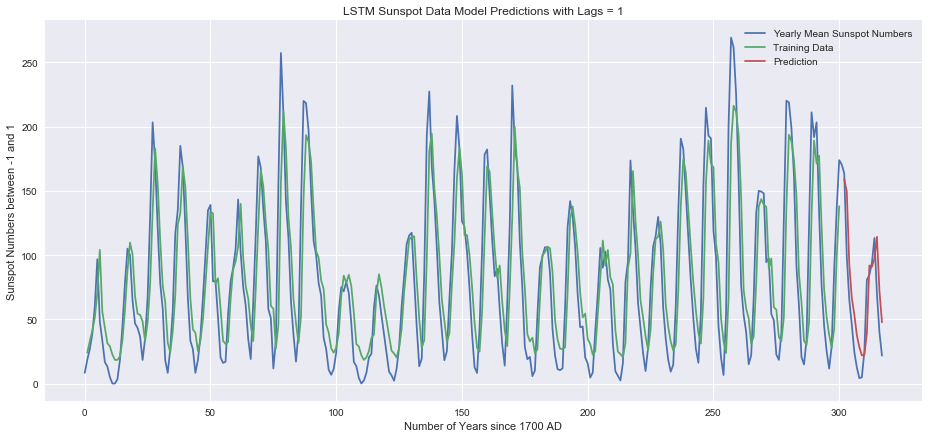

In [613]:
test_obs_inver_sunspots = mms.inverse_transform(test_observed)
test_pres_inver_sunspots = mms.inverse_transform(test_predict)
train_predict_inv = mms.inverse_transform(train_predict)
sunny_spots_inv = mms.inverse_transform(sunny_spots)

print('MAE = ', mean_absolute_error(test_obs_inver_sunspots, test_pres_inver_sunspots))
print('RMSE = ', mean_squared_error(test_obs_inver_sunspots, test_pres_inver_sunspots)**0.5)

# shift train predictions for plotting
train_predict_plot_inv = np.empty_like(sunny_spots)
train_predict_plot_inv[:, :] = np.nan
train_predict_plot_inv[lag:len(train_predict_inv)+lag, :] = train_predict_inv
 
# shift test predictions for plotting
test_predict_plot_inv = np.empty_like(sunny_spots)
test_predict_plot_inv[:, :] = np.nan
test_predict_plot_inv[-len(test_pres_inver_sunspots):, :] = test_pres_inver_sunspots
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(sunny_spots_inv, label='Yearly Mean Sunspot Numbers')
plt.plot(train_predict_plot_inv, label= 'Training Data')
plt.plot(test_predict_plot_inv, label='Prediction')
plt.title('LSTM Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.legend()
plt.show()

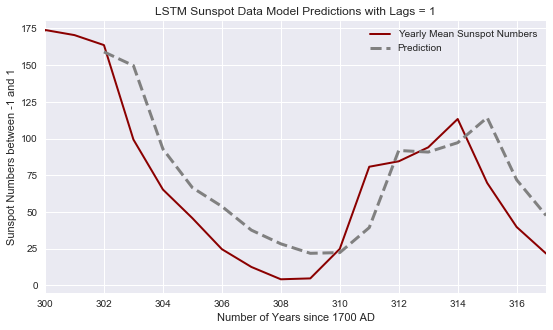

In [609]:
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(sunny_spots_inv, lw=2, color='darkred', label='Yearly Mean Sunspot Numbers')
#plt.plot(train_predict_plot_inv, label= 'Training Data')
plt.plot(test_predict_plot_inv, lw=3, color='grey', ls='dashed',label='Prediction')
plt.title('LSTM Sunspot Data Model Predictions with Lags = 1')
plt.ylabel('Sunspot Numbers between -1 and 1') #Default is 10 bins
plt.xlabel('Number of Years since 1700 AD')
plt.xlim(300,317)
plt.ylim(-5,180)
plt.legend()
plt.show()

# End of Notebook. Thank you.